In [1]:
from __future__ import division

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time
import sys
sys.path.insert(0, '..')

import math
import random
import numpy as np
import pandas as pd
from collections import deque
from scipy.integrate import odeint
from control import lqr
import scipy.integrate as it

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

from algs.td3 import Agent_TD3
from algs.ppo import Agent_PPO
from algs.a2c import Agent_A2C
from envs.env import WoundEnv, SimpleEnv, actuator
from cfgs.config import GetParameters

# Get the current file directory
os.getcwd()

'D:\\Dropbox\\RL4Wound\\codePyV3\\exps'

In [2]:
def readPercentile(data, n_scale=0.2):

    # if not os.path.exists('./{}/'.format(colt_directory)):
    #     os.mkdir('./{}/'.format(colt_directory))

    data_buf = []

    ln = len(data)
    
    for k in range(100):
        noise = np.random.normal(0, n_scale, ln)
        data_tmp = data + noise
        data_buf.append(data_tmp)

    print('rewards collection down. ' + str(len(data_buf)))

    rewards = data_buf

    def stat_rewards(rewards, stat):
        return [stat([r[i] for r in rewards]) for i in range(ln)]

    def sigma(l):
        mean = sum(l) / float(len(l))
        return math.sqrt(sum([(r - mean) ** 2 for r in l]) / (len(l) - 1))

    rewards_mean = stat_rewards(rewards, lambda l: sum(l) / float(len(l)))
    rewards_sigma = stat_rewards(rewards, sigma)
    rewards_up = [rewards_mean[i] + rewards_sigma[i] for i in range(len(rewards_mean))]
    rewards_down = [rewards_mean[i] - rewards_sigma[i] for i in range(len(rewards_mean))]
    rewards_final = [r[-1] for r in rewards]

    rewards_median = stat_rewards(rewards, lambda l: np.percentile(l, 50))
    rewards_90 = stat_rewards(rewards, lambda l: np.percentile(l, 90))
    rewards_75 = stat_rewards(rewards, lambda l: np.percentile(l, 75))
    rewards_25 = stat_rewards(rewards, lambda l: np.percentile(l, 25))
    rewards_10 = stat_rewards(rewards, lambda l: np.percentile(l, 10))

    return rewards_median, rewards_10, rewards_25, rewards_75, rewards_90


In [3]:
def findHealTime(data):
    # new_tissues at all postions
    n_days, n_stages, n_poss = data.shape
    new_tissues = data[:, 4, :].squeeze()
    
    pos_healtime = np.zeros((n_poss))
    radius_wound = np.zeros((n_days))
    
    for pos in range(n_poss):
        for t in range(n_days):
            if new_tissues[t, pos] >= 0.95:
                break
        pos_healtime[pos] = t
        
    for t in range(n_days):
        for pos in range(n_poss):
            if new_tissues[t, pos] >= 0.95:
                break
        radius_wound[t] = pos
    healtime_pos0 = int(pos_healtime[0])
    return healtime_pos0, pos_healtime, radius_wound

In [30]:
args = GetParameters()
args.alg_rl = 'ppo'
args.model_dir = '../res/models/models_{}_lux_0913/'.format(args.alg_rl)
args.data_dir = '../res/data/data_{}_lux_0913/'.format(args.alg_rl)
args.figs_dir = '../res/figs/figs_{}/'.format(args.alg_rl)

dirs = [args.model_dir, args.data_dir, args.figs_dir]
for dir_tmp in dirs:
    if not os.path.exists(dir_tmp):
        os.makedirs(dir_tmp)
env = WoundEnv(args)

In [48]:
args.spt = False
args.t_nums = 240
env = WoundEnv(args)
state = env.reset()
state_buf = np.zeros((0, 5))
for t in range(args.t_nums - 1):
    next_state, reward, done, info = env.step(0)
    state_buf = np.vstack((state_buf, state.reshape(5, -1)[:, 0]))
    state = next_state
state_buf = np.vstack((state_buf, state.reshape(5, -1)[:, 0]))


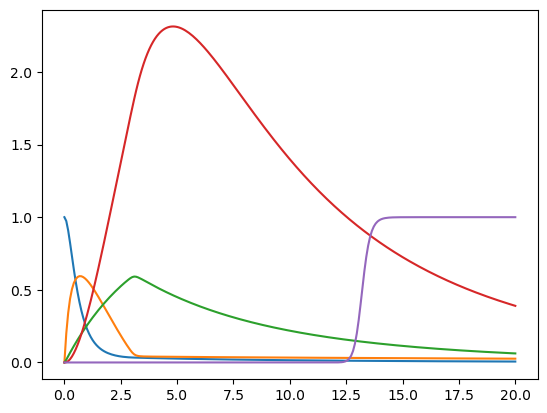

In [54]:
trange = np.linspace(0, 60, args.t_nums) / 3.0
plt.plot(trange, state_buf[:, 0])
plt.plot(trange, state_buf[:, 1])
plt.plot(trange, state_buf[:, 2])
plt.plot(trange, state_buf[:, 3])
plt.plot(trange, state_buf[:, 4])

In [31]:
states_nontreat = pd.read_csv(args.data_dir + 'state_a0_info.csv')
states_nontreat = states_nontreat.values[:, 1:]
states_nontreat = states_nontreat.reshape(601, 5, 100)
states_nontreat[:, 3, 0] = states_nontreat[:, 3, 0] / 5

states_opttreat = pd.read_csv(args.data_dir + 'state_a1_info.csv')
states_opttreat = states_opttreat.values[:, 1:]
states_opttreat = states_opttreat.reshape(601, 5, 100)
states_opttreat[:, 3, 0] = states_opttreat[:, 3, 0] / 5
actions_optODE = np.array([actuator(t, args.t1, args.dt) for t in range(601)])

In [7]:
ht_eps = []
for ep in range(5, 325, 5):
    state_buf = pd.read_csv(args.data_dir + 'state_rl_anum_{}_ep_{}.csv'.format(env.action_space.shape[0], ep))
    state_buf = state_buf.values[:, 1:]
    state_buf = state_buf.reshape(601, 5, 100)
    
    healtime_pos0, pos_healtime, radius_wound = findHealTime(state_buf)
    ht_eps.append(healtime_pos0)

rewards collection down. 100


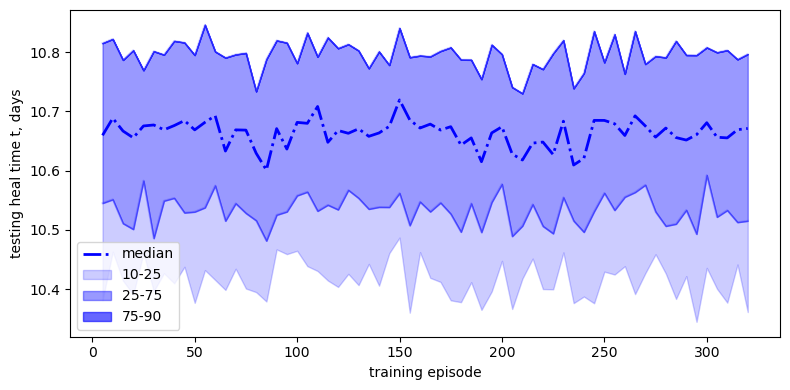

In [8]:
rewards_median, rewards_10, rewards_25, rewards_75, rewards_90 = readPercentile(np.array(ht_eps) / 30, n_scale=0.2)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.plot(range(5, 325, 5), rewards_75, color = 'blue', alpha=0.2)
ax.plot(range(5, 325, 5), rewards_median, color = 'blue', linestyle ='-.', linewidth = 2, label=r'median')
ax.plot(range(5, 325, 5), rewards_25, color = 'blue', alpha=0.2)
ax.fill_between(range(5, 325, 5), rewards_10, rewards_25, color = 'blue', alpha=0.2, label='10-25')
ax.fill_between(range(5, 325, 5), rewards_25, rewards_75, color = 'blue', alpha=0.4, label='25-75')
ax.fill_between(range(5, 325, 5), rewards_75, rewards_75, color = 'blue', alpha=0.6, label='75-90')
ax.set_xlabel('training episode')
ax.set_ylabel('testing heal time t, days')
ax.legend()
plt.tight_layout()
plt.savefig(args.figs_dir + 'train_err_a2c.pdf', format='pdf')
plt.savefig(args.figs_dir + 'train_err_a2c.svg', format='svg')

In [27]:
state_rltreat = pd.read_csv(args.data_dir + 'state_rl_anum_2_ep_240.csv')
state_rltreat = state_rltreat.values[:, 1:]
state_rltreat = state_rltreat.reshape(601, 5, 100)
state_rltreat[:, 3, 0] = state_rltreat[:, 3, 0] / 5

action_rltreat = pd.read_csv(args.data_dir + 'action_rl_anum_2_ep_240.csv')
action_rltreat = action_rltreat.values[:, 1:]
action_rltreat = action_rltreat.squeeze()

In [28]:
ht_nontreat, pos_ht_nontreat, rd_nontreat = findHealTime(states_nontreat)
ht_opttreat, pos_ht_opttreat, rd_opttreat = findHealTime(states_opttreat)
ht_rltreat, pos_ht_rltreat, rd_rltreat = findHealTime(state_rltreat)
# action_rltreat[:max_pro_idx] = action_rltreat[:max_pro_idx] * 0
action_rltreat = np.vstack([np.array([0, 0]).reshape(1, 2), action_rltreat])

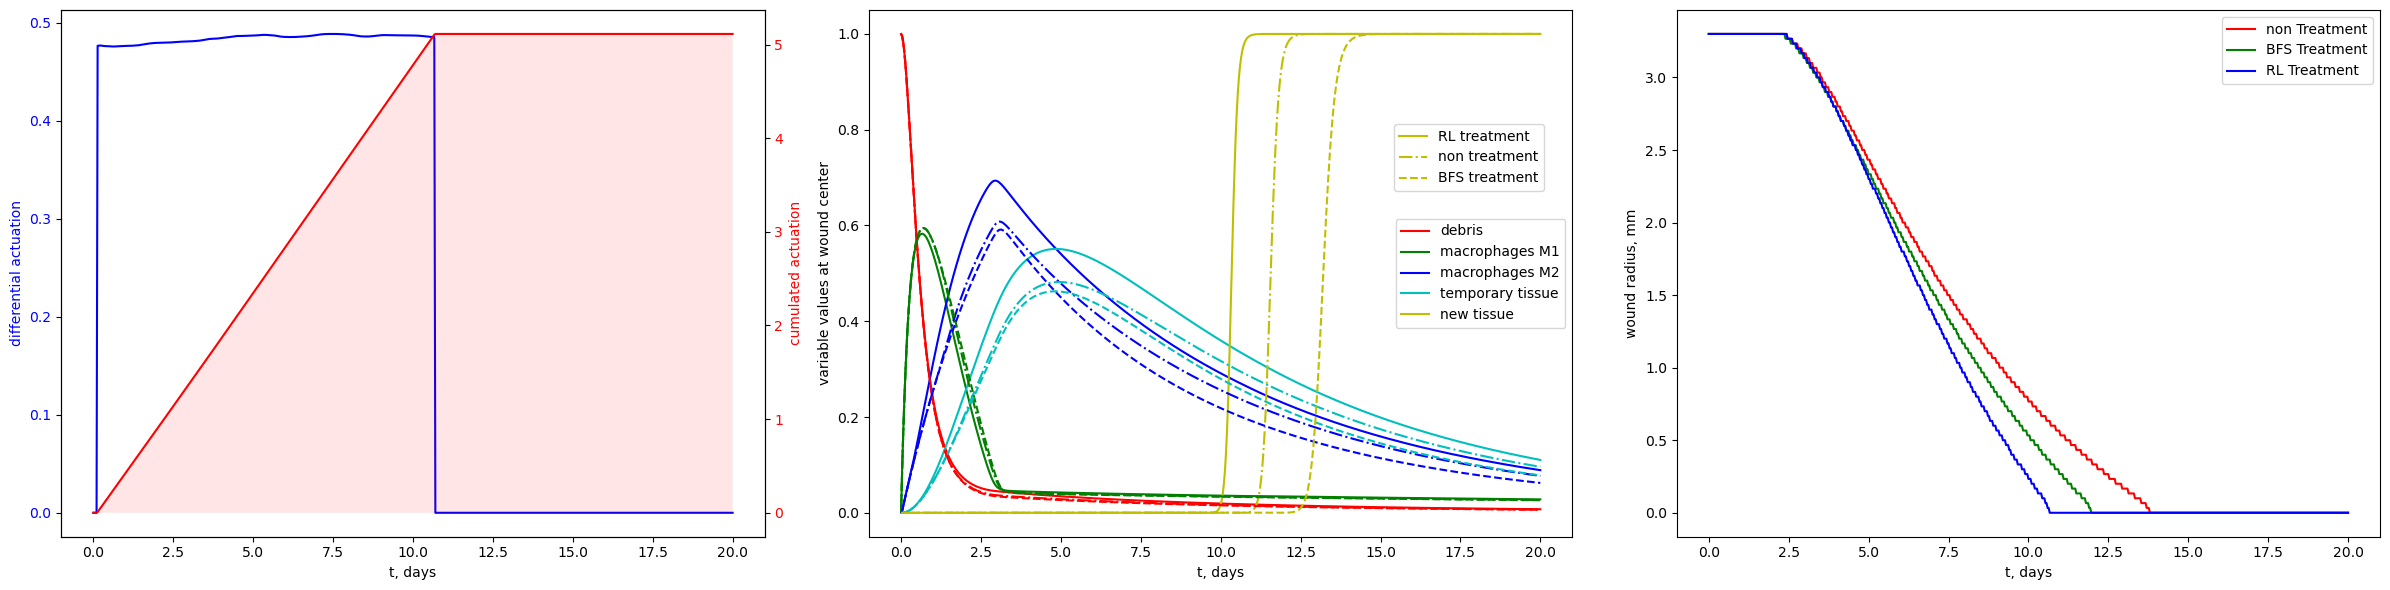

In [29]:
n_days, n_stages, n_poss = states_nontreat.shape

trange = np.linspace(0, env.t_days, env.t_nums) / 3
rd_scale = 30.0


fig = plt.figure(figsize=(24, 6), num=3)

ax = fig.add_subplot(131)
ax.plot(trange, action_rltreat[:, 0], c='b', label='RL Treatment')
# ax.plot(trange, actions_optODE, c='g', label='ODE Treatment')
ax.set_xlabel('t, days')
# ax.set_title('Time dependence of actuator')
ax.set_ylabel('differential actuation', color='b')
ax.tick_params(axis ='y', labelcolor = 'b')
# ax.legend()

ax1 = ax.twinx()
cu_act = it.cumtrapz(action_rltreat[:, 0],initial=0) / 30
ax1.plot(trange, cu_act, c='r')
ax1.set_ylabel('cumulated actuation', color='r')
ax1.fill_between(trange, 0, cu_act, where=0 <= cu_act,
                 facecolor='red', interpolate=True, alpha=0.1)
ax1.tick_params(axis ='y', labelcolor = 'r')

lines = []
ax = fig.add_subplot(132)
ax.plot(trange, state_rltreat[:, 0, 0], c='r', label='debris')
ax.plot(trange, state_rltreat[:, 1, 0], c='g', label='macrophages M1')
ax.plot(trange, state_rltreat[:, 2, 0], c='b', label='macrophages M2')
ax.plot(trange, state_rltreat[:, 3, 0], c='c', label='temporary tissue')
lines += ax.plot(trange, state_rltreat[:, 4, 0], c='y', label='new tissue')

ax.plot(trange, states_opttreat[:, 0, 0], c='r', linestyle='-.')
ax.plot(trange, states_opttreat[:, 1, 0], c='g', linestyle='-.')
ax.plot(trange, states_opttreat[:, 2, 0], c='b', linestyle='-.')
ax.plot(trange, states_opttreat[:, 3, 0], c='c', linestyle='-.')
lines += ax.plot(trange, states_opttreat[:, 4, 0], c='y', linestyle='-.')

ax.plot(trange, states_nontreat[:, 0, 0], c='r', linestyle='--')
ax.plot(trange, states_nontreat[:, 1, 0], c='g', linestyle='--')
ax.plot(trange, states_nontreat[:, 2, 0], c='b', linestyle='--')
ax.plot(trange, states_nontreat[:, 3, 0], c='c', linestyle='--')
lines += ax.plot(trange, states_nontreat[:, 4, 0], c='y', linestyle='--')

# Create the second legend and add the artist manually.
from matplotlib.legend import Legend
leg = Legend(ax, lines, ['RL treatment', 'non treatment', 'BFS treatment'],
             bbox_to_anchor=(0.96, 0.72), 
             loc='center right', borderaxespad=0, frameon=True)
ax.add_artist(leg);

ax.legend()
# ax.set_title('Time dependence of all variables at round center')
ax.set_ylabel('variable values at wound center')
ax.set_xlabel('t, days')


ax = fig.add_subplot(133)
ax.plot(trange, rd_nontreat / rd_scale, c='r', label='non Treatment')
ax.plot(trange, rd_opttreat / rd_scale, c='g', label='BFS Treatment')
ax.plot(trange, radius_wound / rd_scale, c='b', label='RL Treatment')
# ax.set_title('Wound Radius vs. Time')
ax.set_ylabel('wound radius, mm')
ax.set_xlabel('t, days')
ax.legend()

plt.tight_layout()

plt.savefig(args.figs_dir + 'ht_5stage_ode_comp_a2c.pdf', format='pdf')
plt.savefig(args.figs_dir + 'ht_5stage_ode_comp_a2c.svg', format='svg')